Import Packages

In [1]:
# feel free to add more
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score, explained_variance_score

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

Read Data

In [2]:
#df = pd.read_csv('C:/Data/garments_worker_productivity.csv')
df = pd.read_csv('garments_worker_productivity.csv')

In [3]:
# Check which variable contains missing values
print(df.isnull().sum())

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64


In [4]:
# Since about 50% of the observations in wip are missing, we may consider delete this variable, but feel free to use other treatments.
df = df.drop(['wip'], axis = 1)
# Since workday and quarter area already captured in different features, we can probably delete date
df = df.drop(['date'], axis = 1)
# The variable idle_men seems to contain little information that is not already captured by idle time
df = df.drop(['idle_men'], axis = 1)
# Idle time is mostly 0 - thus dichotomizing it makes sense
df['idle_time'] = df['idle_time'].apply(lambda x: 1 if x > 0 else x)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1197 non-null   object 
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   team                   1197 non-null   int64  
 4   targeted_productivity  1197 non-null   float64
 5   smv                    1197 non-null   float64
 6   over_time              1197 non-null   int64  
 7   incentive              1197 non-null   int64  
 8   idle_time              1197 non-null   float64
 9   no_of_style_change     1197 non-null   int64  
 10  no_of_workers          1197 non-null   float64
 11  actual_productivity    1197 non-null   float64
dtypes: float64(5), int64(4), object(3)
memory usage: 112.3+ KB


In [6]:
df.describe()

,team,targeted_productivity,smv,over_time,incentive,idle_time,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,4567.460317,38.210526,0.015038,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,3348.823563,160.182643,0.121753,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,1440.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,3960.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,6960.000000,50.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,25920.000000,3600.000000,1.000000,2.000000,89.000000,1.120437


In [7]:
#create a duplicate column to save no of workers
df['no_of_workers_standardized'] = df.loc[:, 'no_of_workers']
df.head()

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,no_of_style_change,no_of_workers,actual_productivity,no_of_workers_standardized
0,Quarter1,sweing,Thursday,8,0.80,26.16,7080,98,0.0,0,59.0,0.940725,59.0
1,Quarter1,finishing,Thursday,1,0.75,3.94,960,0,0.0,0,8.0,0.886500,8.0
2,Quarter1,sweing,Thursday,11,0.80,11.41,3660,50,0.0,0,30.5,0.800570,30.5
3,Quarter1,sweing,Thursday,12,0.80,11.41,3660,50,0.0,0,30.5,0.800570,30.5
4,Quarter1,sweing,Thursday,6,0.80,25.90,1920,50,0.0,0,56.0,0.800382,56.0


In [8]:
#I made team a category (even though its a number), same with targets and changes
cat_cols = ['quarter', 'department', 'day', 'team', 'targeted_productivity', 'no_of_style_change']
num_cols = ['smv', 'over_time', 'incentive', 'no_of_workers_standardized']
#One hot encoding, dropping the first category
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
#Standardizing all features (not the labels)
scaler= StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# drop duplicate column from dataframe
updated_df = df.drop('no_of_workers', axis=1)

c:\Users\rvira\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


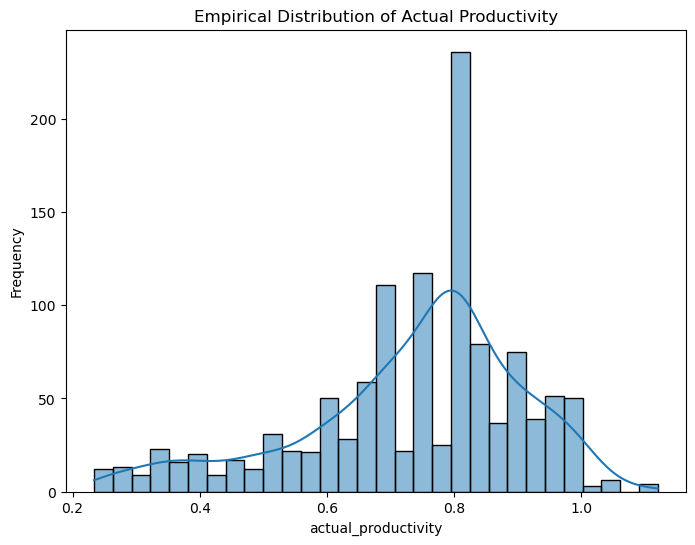

In [9]:
# What is our dependent variable/label?
response_variable = updated_df['actual_productivity']

# Plot the empirical distribution
plt.figure(figsize = (8, 6))
sns.histplot(response_variable, kde = True, bins = 30)  # kde = True plots the kernel density estimate
plt.title('Empirical Distribution of Actual Productivity')
plt.xlabel('actual_productivity')
plt.ylabel('Frequency')
plt.show()

Assuming we are doing a regressing task for now, can you try identify any features thay may contribute to an employee's actual productivity?

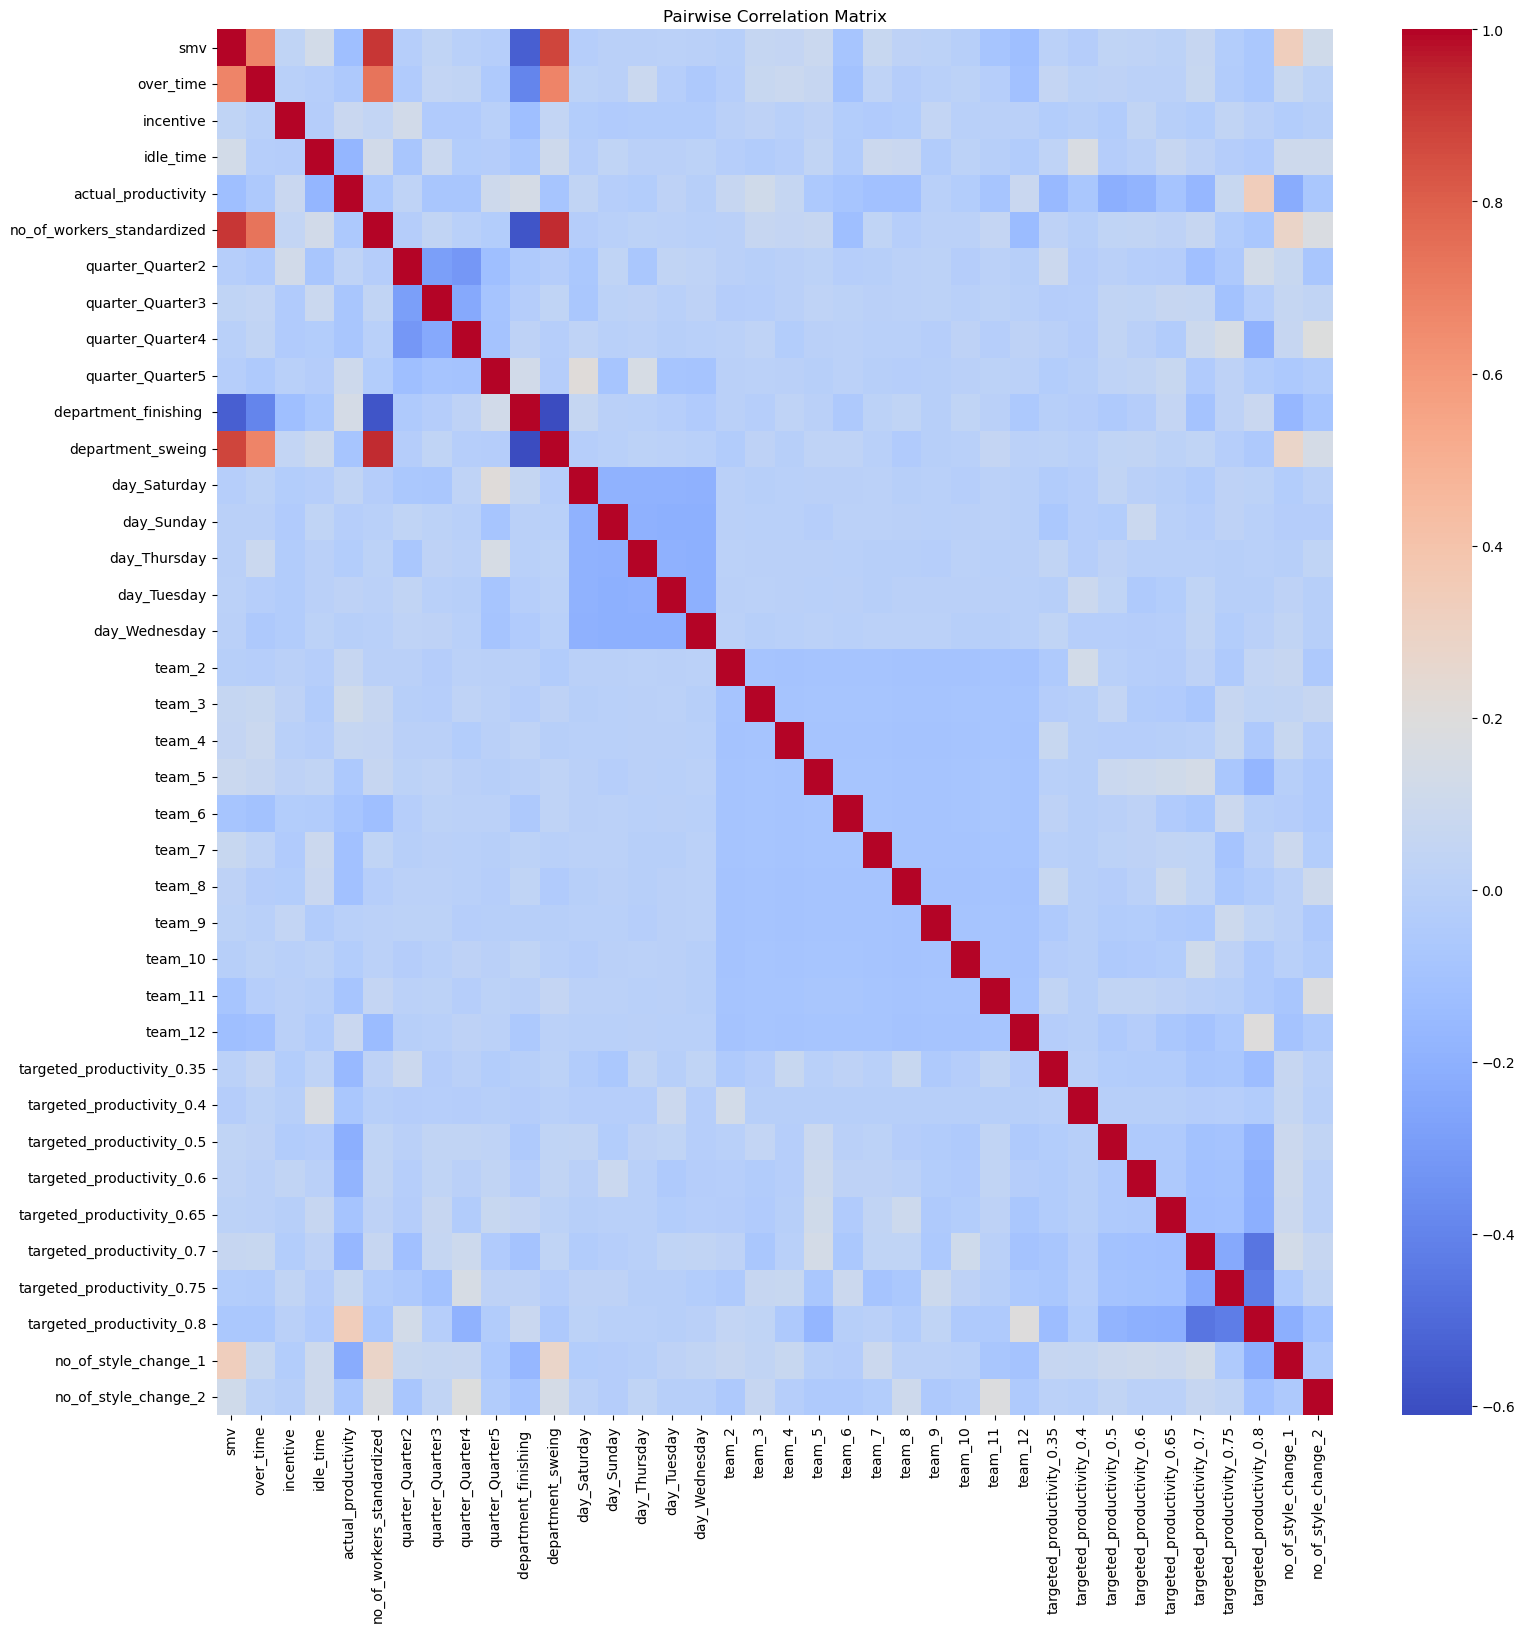

In [10]:
# A grid plot for pairwise correlation may be helpful 

# Compute the correlation matrix
corr_matrix = updated_df.corr()

# Plot the correlation matrix
plt.figure(figsize = (18, 18))
sns.heatmap(corr_matrix, cmap = 'coolwarm', annot=False)
plt.title('Pairwise Correlation Matrix')
plt.show()

# What features are highly correlated to the response?
# what another important signal you see from the correlation matrix?

#### Observations 

1. smv & incentive - shows a relatively high positive coorelation with actual_productivity.
2. idle_time & over_time seem to have negative coorelations with actual_productivity.
3. Different levels of targeted_productivity (0.6, 0.8, etc.) show varying correlations with actual_productivity. Higher targets correlate more positively with actual productivity, but not linearly across all ranges.
4. Some teams (team_7, team_11, team_3) show mild correlations with actual_productivity, indicating performance differences between teams.

### Case 1 - Analyzing worker productivity for Client A

##### Part 1.1 : Identifying the best model using all features

In [11]:
# Splitting the dataset and considering all the features

X = df.drop(['actual_productivity'], axis=1)
y = y = df['actual_productivity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#save the no of workers in a new dataframe
X_train_no_of_workers = pd.DataFrame(df['no_of_workers'])
X_test_no_of_workers = pd.DataFrame(df['no_of_workers'])

# remove the duplicate column no of workers from train and test data
X_train = X_train.drop('no_of_workers', axis=1)
X_test = X_test.drop('no_of_workers', axis=1)

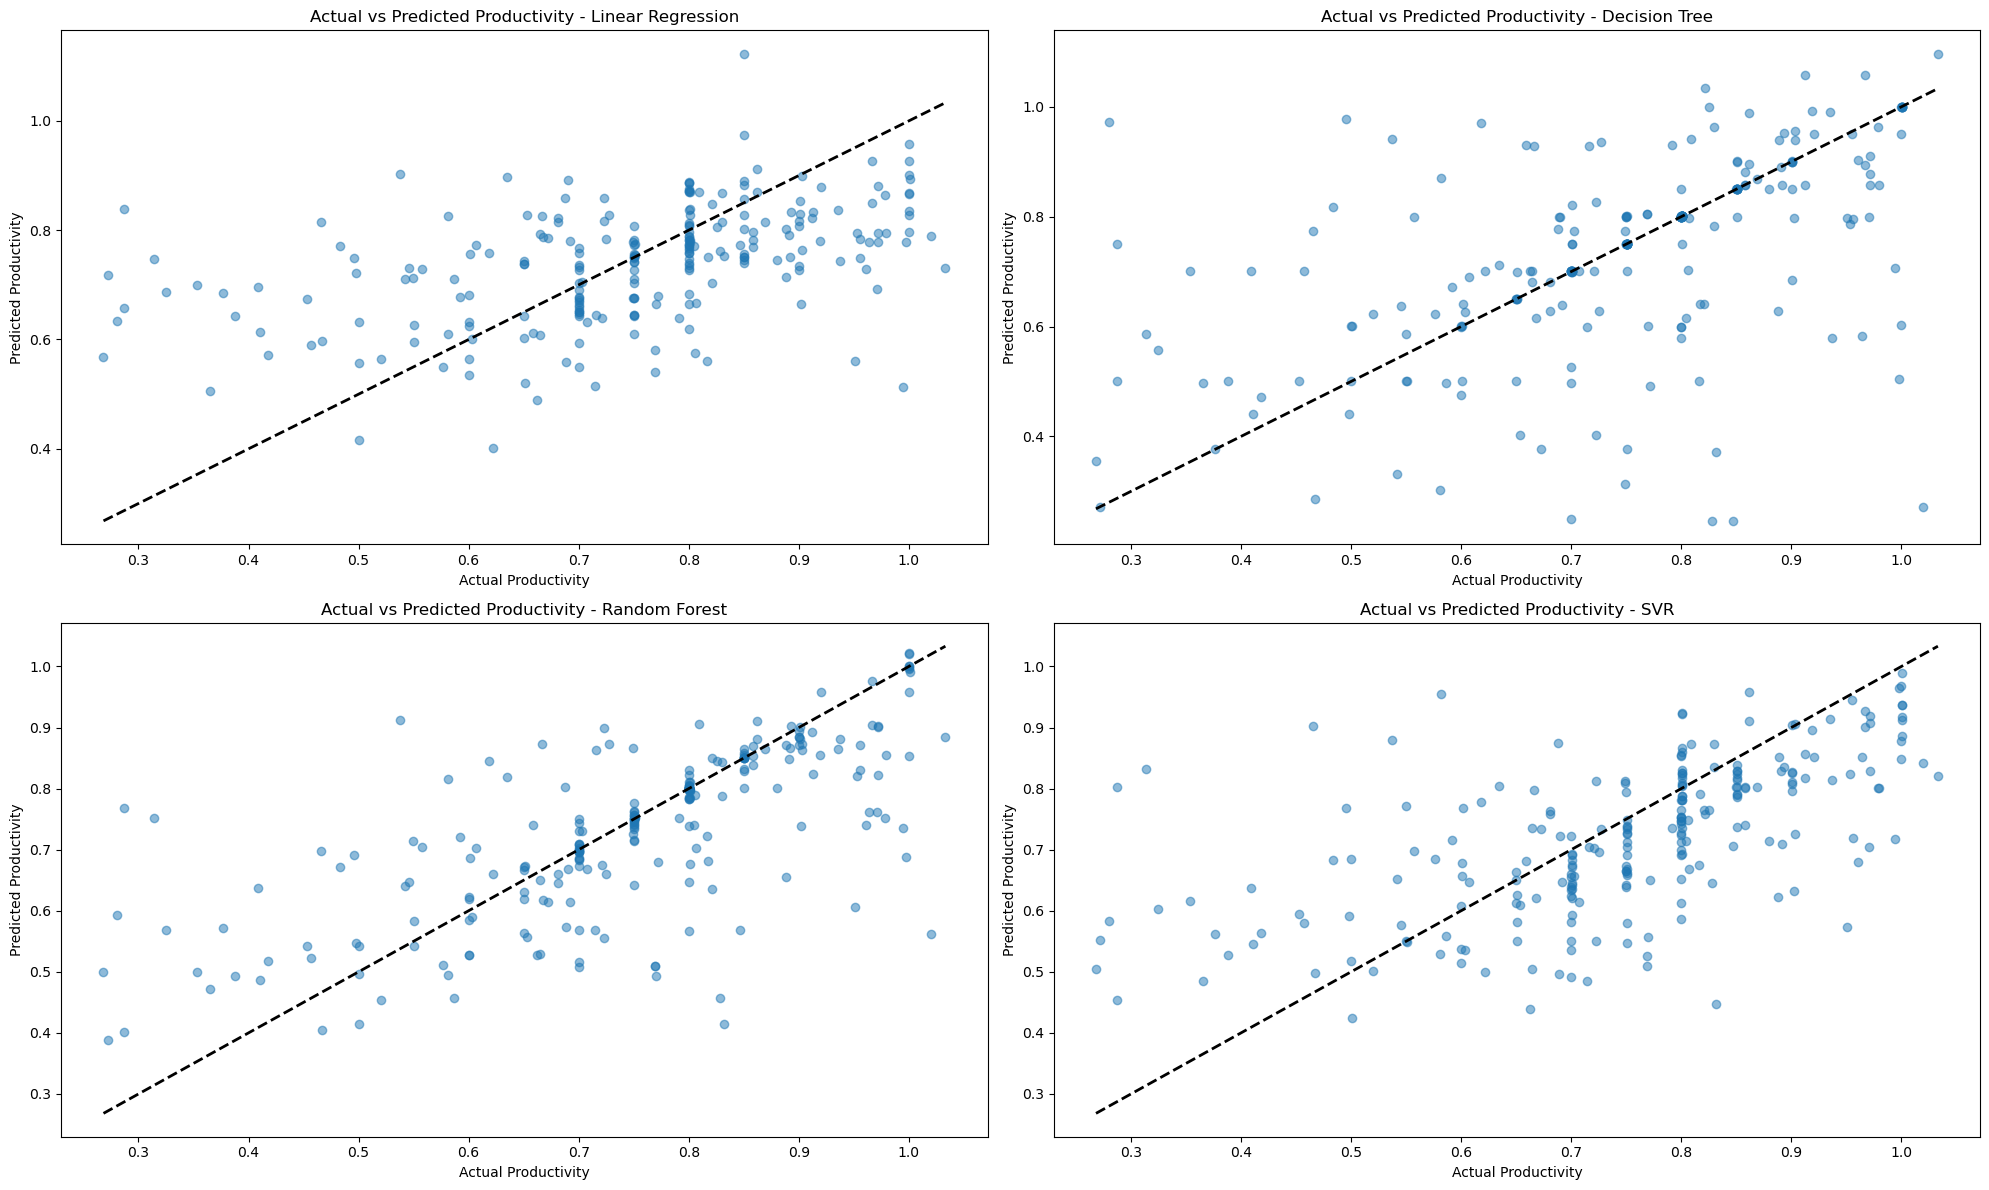

Linear Regression Results:
  RMSE: 0.148
  MAE: 0.112
  R²: 0.176
  Explained Variance: 0.177
  MAPE: 0.185
Decision Tree Results:
  RMSE: 0.167
  MAE: 0.096
  R²: -0.055
  Explained Variance: -0.051
  MAPE: 0.155
Random Forest Results:
  RMSE: 0.121
  MAE: 0.076
  R²: 0.445
  Explained Variance: 0.452
  MAPE: 0.125
SVR Results:
  RMSE: 0.135
  MAE: 0.100
  R²: 0.314
  Explained Variance: 0.338
  MAPE: 0.162


In [12]:
def plot_predictions(y_true, y_pred, model_name, ax):
    ax.scatter(y_true, y_pred, alpha=0.5)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    ax.set_xlabel('Actual Productivity')
    ax.set_ylabel('Predicted Productivity')
    ax.set_title(f'Actual vs Predicted Productivity - {model_name}')

# Prepare a 2x2 grid for subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
axs = axs.flatten()  # Flatten the 2x2 matrix of axes into a 1D array for easier access

results = {}
model_names = ['Linear Regression', 'Decision Tree', 'Random Forest', 'SVR']
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR()
}

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    explained_variance = explained_variance_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Store results
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Explained Variance': explained_variance, 'MAPE': mape}

    # Plot predictions in designated subplot
    plot_predictions(y_test, y_pred, name, axs[i])

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

# Output the metrics results for each model
for model_name, metrics in results.items():
    print(f"{model_name} Results:")
    print(f"  RMSE: {metrics['RMSE']:.3f}")
    print(f"  MAE: {metrics['MAE']:.3f}")
    print(f"  R²: {metrics['R2']:.3f}")
    print(f"  Explained Variance: {metrics['Explained Variance']:.3f}")
    print(f"  MAPE: {metrics['MAPE']:.3f}")

Based on the performance metrics evaluated, the Random Forest model emerges as the superior choice for predicting worker productivity. It has demonstrated the lowest Root Mean Square Error (RMSE) and the lowest Mean Absolute Error (MAE), indicating its predictions are both precise and close to the actual data points. Additionally, it has the highest R² value  and an Explained Variance of 0.452 , suggesting it can explain almost half of the variance in the dataset, which is significantly higher than the other models tested. The Mean Absolute Percentage Error (MAPE) further confirms its reliability in offering predictions that are closest to true values, making it the most suitable model for this dataset and business needs.

In [13]:
# Randon Forest Model Tuning
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 50],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with cross-validation
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, verbose=1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model
best_forest = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [14]:
# Predict the productivity for the test data
predicted_productivity = best_forest.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predicted_productivity ))
r2 = r2_score(y_test, predicted_productivity )

print(f'RMSE: {rmse}')
print(f'R²: {r2}')

RMSE: 0.11728681972579084
R²: 0.48192390830610765


##### Part 1.2: Investigate which features are most influential in the Random Forest model to understand the underlying relationships in the data better and improve the model

In [15]:
#Using random forest to get important features directly from the model
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Train a random forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importance = rf_model.feature_importances_

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Print the top important features
print(importance_df)

                       Feature  Importance
2                    incentive    0.152162
0                          smv    0.109612
4   no_of_workers_standardized    0.109601
1                    over_time    0.093163
34   targeted_productivity_0.8    0.092336
33  targeted_productivity_0.75    0.040753
9        department_finishing     0.040372
7             quarter_Quarter4    0.028739
32   targeted_productivity_0.7    0.022230
15               day_Wednesday    0.021453
5             quarter_Quarter2    0.020856
12                  day_Sunday    0.019816
24                     team_10    0.019608
27  targeted_productivity_0.35    0.018885
11                day_Saturday    0.018406
25                     team_11    0.018335
13                day_Thursday    0.017178
6             quarter_Quarter3    0.016096
21                      team_7    0.011931
29   targeted_productivity_0.5    0.011346
14                 day_Tuesday    0.011277
23                      team_9    0.010632
3          

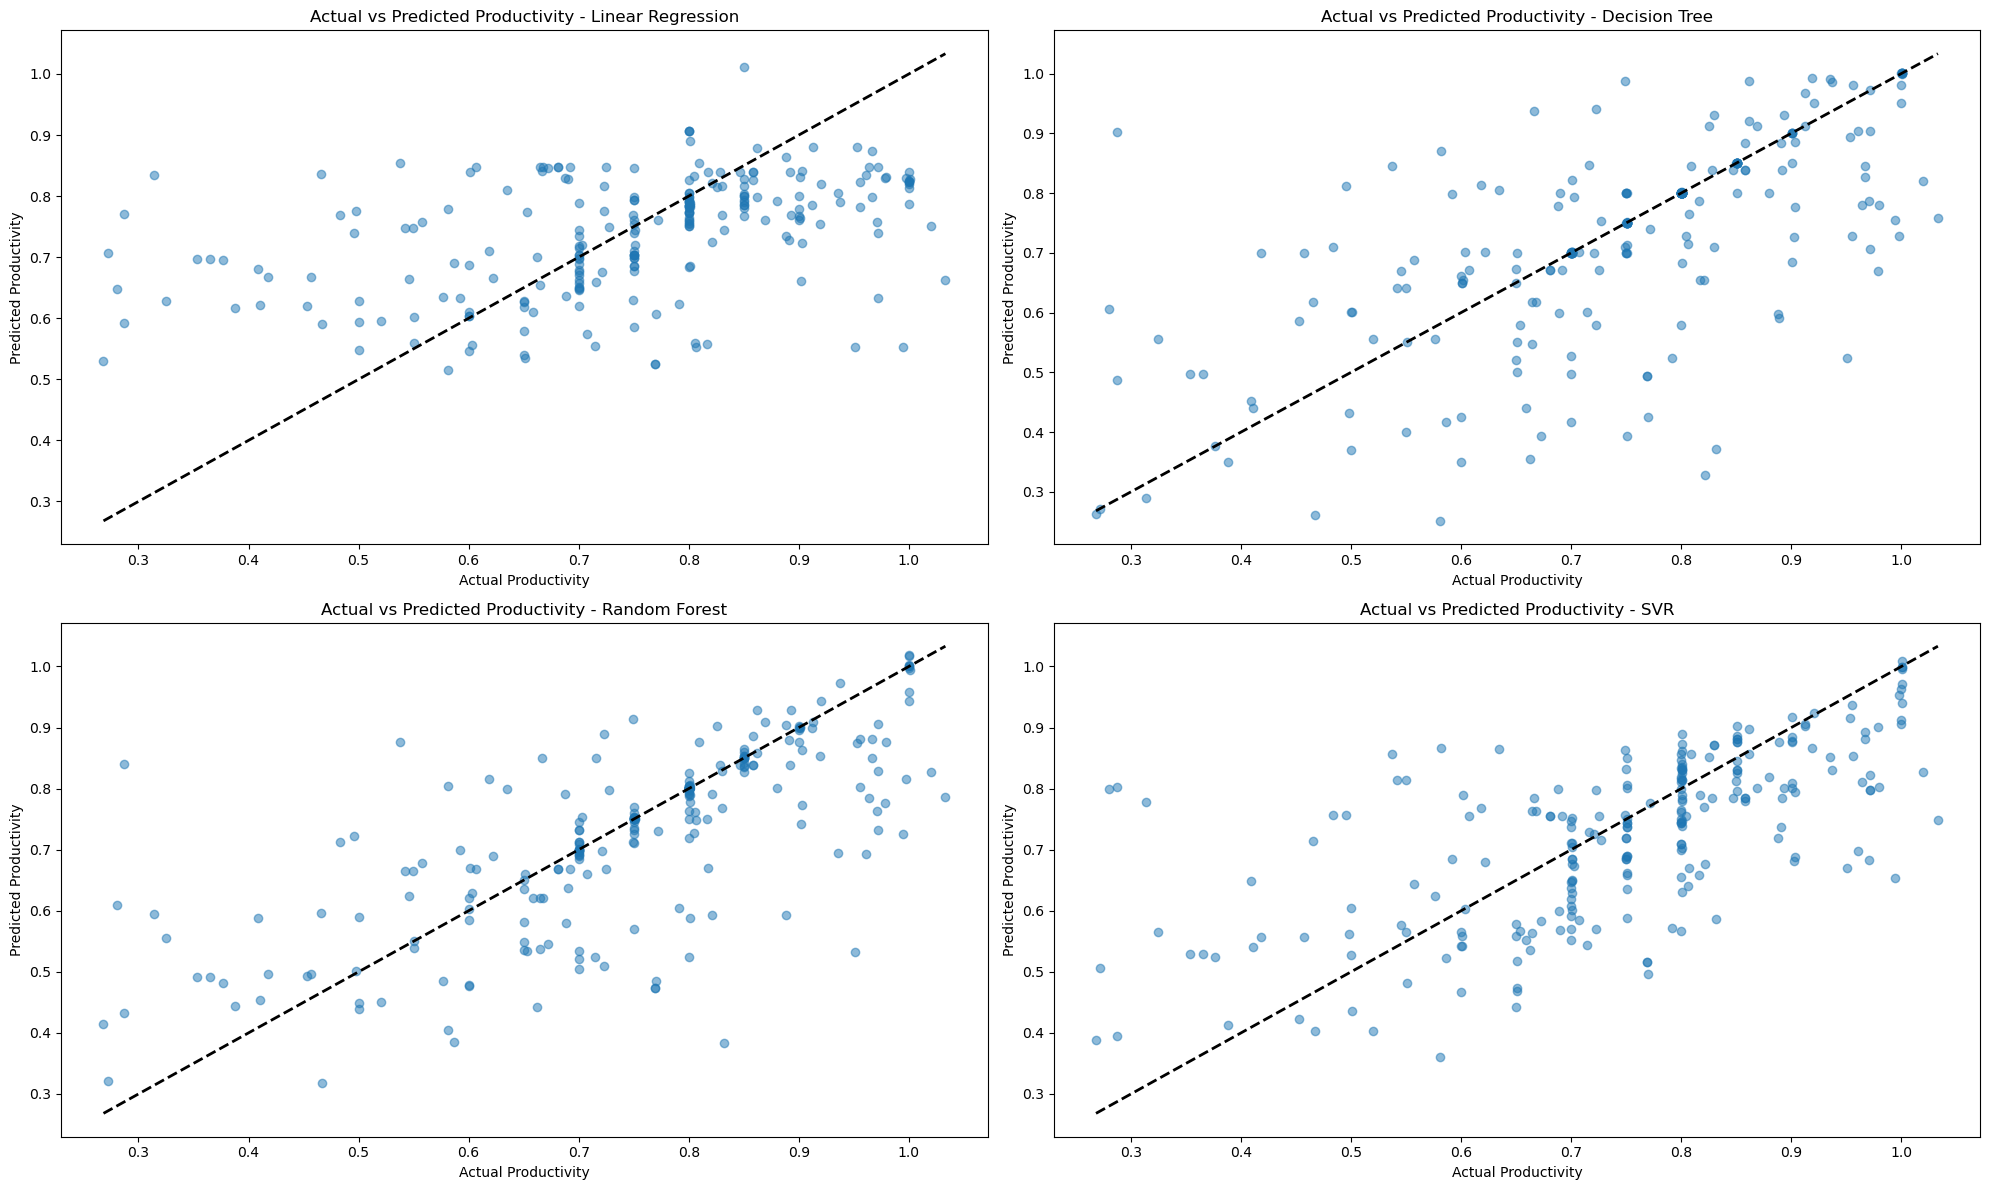

Linear Regression Results:
  RMSE: 0.148
  MAE: 0.108
  R²: 0.174
  Explained Variance: 0.176
  MAPE: 0.179
Decision Tree Results:
  RMSE: 0.139
  MAE: 0.085
  R²: 0.274
  Explained Variance: 0.289
  MAPE: 0.134
Random Forest Results:
  RMSE: 0.119
  MAE: 0.074
  R²: 0.462
  Explained Variance: 0.477
  MAPE: 0.120
SVR Results:
  RMSE: 0.129
  MAE: 0.094
  R²: 0.375
  Explained Variance: 0.391
  MAPE: 0.153


In [16]:
#Selecting the top 10 features based on their absolute coefficients
top_n = 10
importance_df['Absolute_Coefficient'] = importance_df['Importance'].abs()
selected_features = importance_df.nlargest(top_n, 'Absolute_Coefficient')

#filtering training and test datasets
X_train_selected = X_train[selected_features['Feature']]
X_test_selected = X_test[selected_features['Feature']]

#Re training the model based on selected features
def plot_predictions(y_true, y_pred, model_name, ax):
    ax.scatter(y_true, y_pred, alpha=0.5)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    ax.set_xlabel('Actual Productivity')
    ax.set_ylabel('Predicted Productivity')
    ax.set_title(f'Actual vs Predicted Productivity - {model_name}')

# Prepare a 2x2 grid for subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
axs = axs.flatten()  # Flatten the 2x2 matrix of axes into a 1D array for easier access

results = {}
model_names = ['Linear Regression', 'Decision Tree', 'Random Forest', 'SVR']
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR()
}

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    explained_variance = explained_variance_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Store results
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Explained Variance': explained_variance, 'MAPE': mape}

    # Plot predictions in designated subplot
    plot_predictions(y_test, y_pred, name, axs[i])

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

# Output the metrics results for each model
for model_name, metrics in results.items():
    print(f"{model_name} Results:")
    print(f"  RMSE: {metrics['RMSE']:.3f}")
    print(f"  MAE: {metrics['MAE']:.3f}")
    print(f"  R²: {metrics['R2']:.3f}")
    print(f"  Explained Variance: {metrics['Explained Variance']:.3f}")
    print(f"  MAPE: {metrics['MAPE']:.3f}")


The model results indicate that using selected features generally improves predictive performance across all algorithms. The **Random Forest** model shows the best performance with selected features, achieving the lowest RMSE of **0.119** and an R² of **0.462**, compared to an RMSE of **0.121** and R² of **0.445** when all features were used. The **Decision Tree** model also demonstrates notable improvement, with a substantial increase in R² from **-0.055** to **0.279**.

In [17]:
# Randon Forest Model Tuning with selected features
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 50],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with cross-validation
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, verbose=1, scoring='neg_mean_squared_error')
grid_search.fit(X_train_selected, y_train)

# Best model
best_forest = grid_search.best_estimator_

# Predict the productivity for the test data
predicted_productivity = best_forest.predict(X_test_selected)

rmse = np.sqrt(mean_squared_error(y_test, predicted_productivity ))
r2 = r2_score(y_test, predicted_productivity )

print(f'RMSE: {rmse}')
print(f'R²: {r2}')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
RMSE: 0.11644999423540604
R²: 0.4892903397368774


The tuned random forest model with selected features achieved a slightly better performance, showing a lower RMSE of **0.1164** and a higher R² of **0.489** compared to the model without selected features, which had an RMSE of **0.1173** and R² of **0.4819**. Although the difference is not vast, it is statistically significant enough to justify choosing the model with selected features, especially since feature selection can help in reducing complexity and overfitting, leading to a more generalizable model


##### Part 1.3: Applying the decision Rule
Client A will pay P*120 for each worker. Cost of each worker is $70. We will profit only if predicted_productivity > 70/120 i.e 0.583 

Hence our decision rule is as follows:

**We will only place workers whose predicted probability is exceeds 0.58**

In [18]:
# adding number of workers to the testing data
X_test['no_of_workers'] = X_test_no_of_workers

model_profit = []  # List to store the profit for each entry
total_workers = 0  
placed_workers = 0 
unplaced_workers = 0 
model_value = 0

# Iterate over the testing data
for i in range(len(X_test)):
    num_workers = X_test.iloc[i]['no_of_workers']  # Accessing number of workers for each entry by position
    total_workers += num_workers  # Update total workers
    
    if predicted_productivity[i] > 0.58:
        profit_value = (predicted_productivity[i] * 120 - 70) * num_workers
        model_profit.append(profit_value)
        placed_workers += num_workers  
    else:
        model_profit.append(0)  # If condition is not met, profit is 0
        unplaced_workers += num_workers  

# Calculate total profit
total_model_profit = sum(model_profit)

# Calculate percentages
placed_percentage = (placed_workers / total_workers) * 100 if total_workers > 0 else 0
unplaced_percentage = (unplaced_workers / total_workers) * 100 if total_workers > 0 else 0

# Output total model profit
print(f"Total model Profit: ${total_model_profit:.2f}")
print(f"Count of Workers placed: {placed_workers:.1f}")
print(f"Count of Workers unplaced: {unplaced_workers:.1f}")
print(f"Percentage of Workers placed: {placed_percentage:.2f}%")
print(f"Percentage of Workers unplaced: {unplaced_percentage:.2f}%")


Total model Profit: $166447.07
Count of Workers placed: 7113.0
Count of Workers unplaced: 1900.0
Percentage of Workers placed: 78.92%
Percentage of Workers unplaced: 21.08%


##### Part 1.4: Calculating the Financial Value of our Model.

Part 1.4A - Calculating the value of model by randomly placing workers based on predicted productivity

In [19]:
# Create a new DataFrame that only contains the 'no_of_workers' column and predicted productivity
y_pred_series = pd.Series(predicted_productivity, name='y_pred')

workers_and_pred_df = pd.DataFrame({
    'no_of_workers': X_test['no_of_workers'].reset_index(drop=True),
    'y_pred': y_pred_series.reset_index(drop=True)
})

workers_and_pred_df.head()

,no_of_workers,y_pred
0,42.0,0.428279
1,31.0,0.795804
2,8.0,0.678595
3,8.0,0.526700
4,8.0,0.664348


In [20]:
target_workers = placed_workers
# Initialize a list to store the model profits for averaging later
model_profits = []

# Run the random profit calculation 5 times
for _ in range(5):
    # Randomly shuffle the DataFrame rows
    shuffled_df = workers_and_pred_df.sample(frac=1).reset_index(drop=True)

    # Initialize variables to accumulate workers and calculate random profit
    accumulated_workers = 0
    total_profit = 0

    # Iterate through the shuffled DataFrame and accumulate workers
    for index, row in shuffled_df.iterrows():
        num_workers = row['no_of_workers']
        pred_value = row['y_pred']

        # Check if adding this row would exceed the target worker count
        if accumulated_workers + num_workers <= target_workers:
            # Add the entire row
            accumulated_workers += num_workers
            profit_value = (pred_value * 120 - 70) * num_workers
            total_profit += profit_value
        else:
            # Add only the remaining workers needed to reach the target
            remaining_workers = target_workers - accumulated_workers
            accumulated_workers += remaining_workers
            profit_value = (pred_value * 120 - 70) * remaining_workers
            total_profit += profit_value
            break  # Stop once we've reached the target number of workers

    # Append the calculated model profit for this run
    model_profits.append(total_profit)

# Calculate the average model profit over the 5 runs
average_model_profit = np.mean(model_profits)

# Output the results
print(f"Model Profits for 5 runs by placing workers randomly based on predicted results: {[f'${profit:.2f}' for profit in model_profits]}")
print(f"Average Random Profit: ${average_model_profit:.2f}")
print(f"Estimated model Profit with decision rule: ${total_model_profit:.2f}")

# Model Value 
model_value = total_model_profit - average_model_profit
print(f"Model value: ${model_value:.2f}")


Model Profits for 5 runs by placing workers randomly based on predicted results: ['$112591.14', '$114852.66', '$109171.33', '$104555.58', '$114577.89']
Average Random Profit: $111149.72
Estimated model Profit with decision rule: $166447.07
Model value: $55297.35


Part 1.4B - Calculating the value of our model by randomly placing workers based on actual productivity 

In [21]:
# Create a new DataFrame that only contains the 'no_of_workers' column and actual productivity
y_actual_series = pd.Series(y_test, name='y_actual')

workers_and_actual_df = pd.DataFrame({
    'no_of_workers': X_test['no_of_workers'].reset_index(drop=True),
    'y_actual': y_pred_series.reset_index(drop=True)
})

workers_and_actual_df.head()

,no_of_workers,y_actual
0,42.0,0.428279
1,31.0,0.795804
2,8.0,0.678595
3,8.0,0.526700
4,8.0,0.664348


In [22]:
target_workers = placed_workers
# Initialize a list to store the model profits for averaging later
actual_profits = []

# Run the random profit calculation 5 times on actual dataset
for _ in range(5):
    # Randomly shuffle the DataFrame rows
    shuffled_df = workers_and_actual_df.sample(frac=1).reset_index(drop=True)

    # Initialize variables to accumulate workers and calculate random profit
    accumulated_workers = 0
    total_profit = 0

    # Iterate through the shuffled DataFrame and accumulate workers
    for index, row in shuffled_df.iterrows():
        num_workers = row['no_of_workers']
        actual_value = row['y_actual']

        # Check if adding this row would exceed the target worker count
        if accumulated_workers + num_workers <= target_workers:
            # Add the entire row
            accumulated_workers += num_workers
            profit_value = (actual_value * 120 - 70) * num_workers
            total_profit += profit_value
        else:
            # Add only the remaining workers needed to reach the target
            remaining_workers = target_workers - accumulated_workers
            accumulated_workers += remaining_workers
            profit_value = (actual_value * 120 - 70) * remaining_workers
            total_profit += profit_value
            break  # Stop once we've reached the target number of workers

    # Append the calculated model profit for this run
    actual_profits.append(total_profit)

# Calculate the average model profit over the 5 runs
average_model_profit = np.mean(actual_profits)

# Output the results
print(f"Profits for 5 runs by placing workers randomly using actual productivity: {[f'${profit:.2f}' for profit in actual_profits]}")
print(f"Average Random Profit: ${average_model_profit:.2f}")
print(f"Estimated model Profit with decision rule: ${total_model_profit:.2f}")

# Model Value 
model_value = total_model_profit - average_model_profit
print(f"Model value: ${model_value:.2f}")

Profits for 5 runs by placing workers randomly using actual productivity: ['$123141.25', '$118556.15', '$117241.02', '$113692.35', '$117008.07']
Average Random Profit: $117927.77
Estimated model Profit with decision rule: $166447.07
Model value: $48519.30


### Case 2 - Analyzing worker productivity for Client B

Part 2.1 - Identifying the best model based on all features

In [23]:
#splitting the data based on all features

X = df.drop(['actual_productivity'], axis=1)
y = (df['actual_productivity'] > 0.8).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#save the no of workers in a new dataframe
X_train_no_of_workers = pd.DataFrame(df['no_of_workers'])
X_test_no_of_workers = pd.DataFrame(df['no_of_workers'])

# remove the duplicate column no of workers from train and test data
X_train = X_train.drop('no_of_workers', axis=1)
X_test = X_test.drop('no_of_workers', axis=1)



actual_productivity
0    510
1    447
Name: count, dtype: int64
actual_productivity
0    53.291536
1    46.708464
Name: proportion, dtype: float64


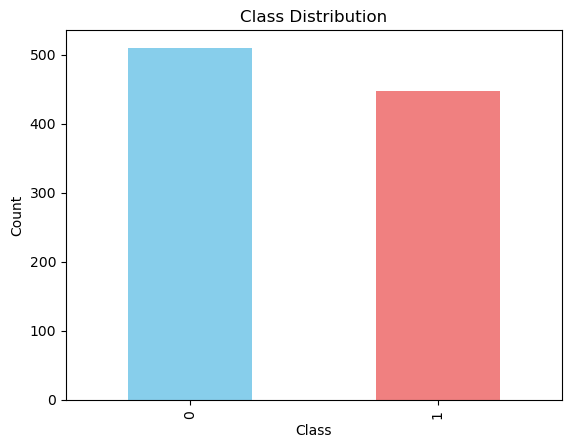

In [24]:
#Check for class imbalance
class_counts = y_train.value_counts()
print(class_counts)

# Calculate the proportion of each class
class_proportions = y_train.value_counts(normalize=True) * 100
print(class_proportions)

# Visualize the class distribution using a bar plot
class_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Training Data shows a fairly balanced class distribution, with 53.29% of instances labeled as class 0 and 46.71% as class 1. There is no significant class imbalance in this dataset.

In [25]:
# Initialize models
log_reg = LogisticRegression()
rf = RandomForestClassifier(random_state=42)
svm = SVC(random_state=42)

# Train and predict with Logistic Regression
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# Train and predict with Random Forest
rf.fit(X_train, y_train) 
y_pred_rf = rf.predict(X_test)

# Train and predict with SVM
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Evaluate and compare models
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

# Optional: Print classification reports for detailed metrics
print("\nLogistic Regression Report:\n", classification_report(y_test, y_pred_log))
print("\nRandom Forest Report:\n", classification_report(y_test, y_pred_rf))
print("\nSVM Report:\n", classification_report(y_test, y_pred_svm))


Logistic Regression Accuracy: 0.8
Random Forest Accuracy: 0.8625
SVM Accuracy: 0.8416666666666667

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80       128
           1       0.76      0.83      0.79       112

    accuracy                           0.80       240
   macro avg       0.80      0.80      0.80       240
weighted avg       0.80      0.80      0.80       240


Random Forest Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       128
           1       0.86      0.84      0.85       112

    accuracy                           0.86       240
   macro avg       0.86      0.86      0.86       240
weighted avg       0.86      0.86      0.86       240


SVM Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85       128
           1       0.82      0.84      0.83       112

    accuracy    

The classification reports show that Random Forest performs best with an accuracy of 86.25%, followed by SVM with 84.17%, and Logistic Regression with 80%. Random Forest has the highest precision and recall for both classes (0 and 1), indicating it balances the trade-off between false positives and false negatives better. All models have fairly balanced precision and recall, but Random Forest outperforms in both metrics, especially for class 1. Overall, Random Forest is the most effective model for this classification problem based on these metrics.

##### Part 2.2: Improving the Model Using Feature Selection & Hyperparameter Tuning

In [26]:
# Train a Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Get feature importance scores
feature_importances = rf.feature_importances_

# Sort and select top N features
indices = np.argsort(feature_importances)[::-1]  # Sort in descending order
top_n_features = indices[:10]  # Select top 5 features

# Print feature rankings
for idx in top_n_features:
    print(f"Feature {idx}: Importance {feature_importances[idx]}")

# Selecting top features
X_train_rf = X_train.iloc[:, top_n_features]  # For DataFrame
X_test_rf = X_test.iloc[:, top_n_features]

# Refit Random Forest with top N features
rf.fit(X_train_rf, y_train)
y_pred_rf = rf.predict(X_test_rf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy with Selected Features:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Feature 2: Importance 0.1439770177831711
Feature 34: Importance 0.13274956421567066
Feature 0: Importance 0.11638616097510812
Feature 1: Importance 0.10102575828729403
Feature 4: Importance 0.09182517153671746
Feature 32: Importance 0.03200846880059993
Feature 9: Importance 0.029228212911135754
Feature 10: Importance 0.022210643366898264
Feature 15: Importance 0.019245812524092066
Feature 13: Importance 0.018588681958784804
Random Forest Accuracy with Selected Features: 0.8875
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       128
           1       0.89      0.87      0.88       112

    accuracy                           0.89       240
   macro avg       0.89      0.89      0.89       240
weighted avg       0.89      0.89      0.89       240



The Random Forest model based on selected features achieved an accuracy of **0.887** with improved precision and recall for both classes compared to the model using all features, which had an accuracy of **0.860**. The selected features resulted in a better overall performance, particularly enhancing the classification metrics for class **1**. This suggests that feature selection effectively improved the model's predictive capabilities.

In [46]:
#Finding best parameters based on selected features

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_rf, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the model with the best parameters found through hyperparameter tuning
best_params = {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
rf_best = RandomForestClassifier(**best_params, random_state=42)

# Fit the model on the training data
rf_best.fit(X_train_rf, y_train)

# Predict on the test data
y_pred_best = rf_best.predict(X_test_rf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_best)
report = classification_report(y_test, y_pred_best)

# Print the results
print(f"Random Forest Accuracy with Selected Features and Best Parameters: {accuracy:.4f}")
print("Classification Report:")
print(report)


# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred_best)

# Extract TP, TN, FP, FN
TN, FP, FN, TP = confusion_mat.ravel()

# Print the results
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")



Random Forest Accuracy with Selected Features and Best Parameters: 0.8958
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       128
           1       0.88      0.89      0.89       112

    accuracy                           0.90       240
   macro avg       0.90      0.90      0.90       240
weighted avg       0.90      0.90      0.90       240

True Negatives (TN): 115
False Positives (FP): 13
False Negatives (FN): 12
True Positives (TP): 100


Using the top 10 features along with optimized hyperparameters, the Random Forest model achieved an accuracy of 0.8958 with improved precision and recall compared to the model using all features, which had an accuracy of 0.86. 

##### Part 2.3 - Applying the Decision Rule

The profit for each outcome can be defined as follows:

1.Profit from True Positives (TP): $250 (payment) - $70 (cost) = $180 per correct placement.

2.Profit from False Positives (FP): $0 (no payment) - $70 (cost) = -$70 per incorrect placement.

3.TN and FN can be dropped as we might not gain or lose directly. (Will only miss out on potential revenue from FN values)

In [48]:
# adding number of workers to the testing data
X_test['no_of_workers'] = X_test_no_of_workers

# Create a new DataFrame that only contains the 'no_of_workers' column and predicted productivity
y_pred_series = pd.Series(y_pred_best, name='y_pred')

workers_and_pred_df = pd.DataFrame({
    'no_of_workers': X_test['no_of_workers'].reset_index(drop=True),
    'y_pred': y_pred_series.reset_index(drop=True),
    'y_actual': y_test.reset_index(drop=True)
})

# Initialize TP, TN, FP, FN counts
df['case'] = None

# Map each case to TP, TN, FP, FN
workers_and_pred_df.loc[(workers_and_pred_df['y_pred'] == 1) & (workers_and_pred_df['y_actual'] == 1), 'case'] = 'TP'
workers_and_pred_df.loc[(workers_and_pred_df['y_pred'] == 0) & (workers_and_pred_df['y_actual'] == 0), 'case'] = 'TN'
workers_and_pred_df.loc[(workers_and_pred_df['y_pred'] == 1) & (workers_and_pred_df['y_actual'] == 0), 'case'] = 'FP'
workers_and_pred_df.loc[(workers_and_pred_df['y_pred'] == 0) & (workers_and_pred_df['y_actual'] == 1), 'case'] = 'FN'

# Group by the case type and sum the number of workers
worker_summary = workers_and_pred_df.groupby('case')['no_of_workers'].sum().reset_index()

print(worker_summary)

  case  no_of_workers
0   FN          253.0
1   FP          295.0
2   TN         4830.5
3   TP         3634.5


In [ ]:
no_of_workers_test = X_test['no_of_workers'].values
y_probs = rf_best.predict_proba(X_test_rf)[:, 1]  # Probabilities for class 1 (productivity > 0.8)
y_true = y_test

thresholds_df = pd.DataFrame(columns=['Threshold', 'TP', 'FP', 'TP Workers', 'FP Workers'])


thresholds = np.arange(0, 1.00, 0.02)  # Range of thresholds from 0 to 1
tp_list = []
fp_list = []
tp_workers_list = []
fp_workers_list = []

# Iterate over the range of thresholds
for threshold in thresholds:
    # Predict class labels based on the current threshold
    y_pred_threshold = (y_probs >= threshold).astype(int)
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_threshold).ravel()
    
    # Get True Positives (TP) and False Positives (FP) indices
    tp_indices = (y_pred_threshold == 1) & (y_true == 1)  # True Positives
    fp_indices = (y_pred_threshold == 1) & (y_true == 0)  # False Positives
    
    # Sum the number of workers corresponding to TP and FP cases
    tp_workers = no_of_workers_test[tp_indices].sum()
    fp_workers = no_of_workers_test[fp_indices].sum()
    
    # Append the TP, FP, and number of workers values for this threshold to their respective lists
    tp_list.append(tp)
    fp_list.append(fp)
    tp_workers_list.append(tp_workers)
    fp_workers_list.append(fp_workers)

# Display the thresholds, TP, FP, and corresponding worker values
for i, threshold in enumerate(thresholds):
    result_df = pd.DataFrame({
        'Threshold': [threshold],
        'TP': tp_list[i],
        'FP': fp_list[i],
        'TP Workers': tp_workers_list[i],
        'FP Workers': fp_workers_list[i]
    })

    # Append the new DataFrame (row) to the results_df DataFrame
    thresholds_df = pd.concat([thresholds_df, result_df], ignore_index=True)

    print(f"Threshold: {threshold:.2f} | TP: {tp_list[i]} | FP: {fp_list[i]} | TP Workers: {tp_workers_list[i]} | FP Workers: {fp_workers_list[i]}")


Threshold: 0.00 | TP: 112 | FP: 128 | TP Workers: 3887.5 | FP Workers: 5125.5
Threshold: 0.02 | TP: 111 | FP: 74 | TP Workers: 3879.5 | FP Workers: 2525.5
Threshold: 0.04 | TP: 111 | FP: 63 | TP Workers: 3879.5 | FP Workers: 2071.0
Threshold: 0.06 | TP: 111 | FP: 61 | TP Workers: 3879.5 | FP Workers: 1957.0
Threshold: 0.08 | TP: 111 | FP: 54 | TP Workers: 3879.5 | FP Workers: 1756.0
Threshold: 0.10 | TP: 111 | FP: 51 | TP Workers: 3879.5 | FP Workers: 1632.0
Threshold: 0.12 | TP: 110 | FP: 43 | TP Workers: 3871.5 | FP Workers: 1259.5
Threshold: 0.14 | TP: 109 | FP: 38 | TP Workers: 3863.5 | FP Workers: 1119.5
Threshold: 0.16 | TP: 108 | FP: 36 | TP Workers: 3804.5 | FP Workers: 1052.5
Threshold: 0.18 | TP: 108 | FP: 33 | TP Workers: 3804.5 | FP Workers: 877.0
Threshold: 0.20 | TP: 108 | FP: 33 | TP Workers: 3804.5 | FP Workers: 877.0
Threshold: 0.22 | TP: 106 | FP: 30 | TP Workers: 3744.5 | FP Workers: 805.0
Threshold: 0.24 | TP: 105 | FP: 30 | TP Workers: 3736.5 | FP Workers: 805.0
Th

C:\Users\rvira\AppData\Local\Temp\ipykernel_12528\4109907290.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  thresholds_df = pd.concat([thresholds_df, result_df], ignore_index=True)


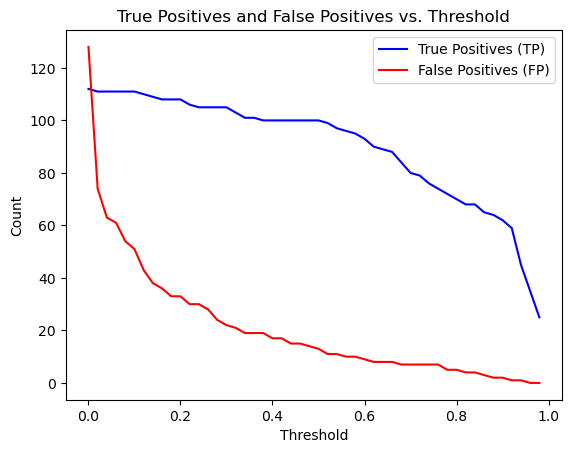

In [74]:
import matplotlib.pyplot as plt

# Plot TP and FP against the thresholds
plt.plot(thresholds, tp_list, label='True Positives (TP)', color='blue')
plt.plot(thresholds, fp_list, label='False Positives (FP)', color='red')

# Add labels and legend
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.title('True Positives and False Positives vs. Threshold')
plt.legend()

# Show the plot
plt.show()

In [75]:
# Initialize a list to store profits
profits = []

# Iterate over all thresholds to calculate the total profit
for i, threshold in enumerate(thresholds):
    # Calculate the total profit for the current threshold
    total_profit = (180 * tp_workers_list[i]) - (70 * fp_workers_list[i])
    
    # Append the profit to the list
    profits.append(total_profit)

    # Print the threshold along with the profit
    print(f"Threshold: {threshold:.2f} | Profit: {total_profit:.2f}")

# Find the index of the maximum profit
max_profit_index = np.argmax(profits)
best_threshold = thresholds[max_profit_index]
best_profit = profits[max_profit_index]

# Display the best threshold and the corresponding profit
print(f"\nBest Threshold: {best_threshold:.2f} | Maximum Profit: ${best_profit:.2f}")

Threshold: 0.00 | Profit: 340965.00
Threshold: 0.02 | Profit: 521525.00
Threshold: 0.04 | Profit: 553340.00
Threshold: 0.06 | Profit: 561320.00
Threshold: 0.08 | Profit: 575390.00
Threshold: 0.10 | Profit: 584070.00
Threshold: 0.12 | Profit: 608705.00
Threshold: 0.14 | Profit: 617065.00
Threshold: 0.16 | Profit: 611135.00
Threshold: 0.18 | Profit: 623420.00
Threshold: 0.20 | Profit: 623420.00
Threshold: 0.22 | Profit: 617660.00
Threshold: 0.24 | Profit: 616220.00
Threshold: 0.26 | Profit: 617340.00
Threshold: 0.28 | Profit: 626300.00
Threshold: 0.30 | Profit: 627420.00
Threshold: 0.32 | Profit: 628635.00
Threshold: 0.34 | Profit: 628360.00
Threshold: 0.36 | Profit: 628360.00
Threshold: 0.38 | Profit: 617740.00
Threshold: 0.40 | Profit: 620820.00
Threshold: 0.42 | Profit: 620820.00
Threshold: 0.44 | Profit: 628730.00
Threshold: 0.46 | Profit: 628730.00
Threshold: 0.48 | Profit: 632720.00
Threshold: 0.50 | Profit: 633560.00
Threshold: 0.52 | Profit: 632660.00
Threshold: 0.54 | Profit: 61

As the threshold increases, True Positives decrease while False Positives also decline, with a notable balance at 0.50 considering the amount of workers. Higher thresholds reduce False Positives further but risk missing productive workers. Hence our Decision rule is:
 
**Only place workers whose predicted probability of exceeding a productivity score is greater than 0.80, and the threshold for placement is 0.50.**


##### Part 2.4: Calculating the Financial Value of our Model.

Part 2.4A - Calculating the value of model in terms of randomly placing the workers as per model results

In [83]:
# Filter the DataFrame for threshold 0.50
best_threshold_df = thresholds_df[thresholds_df['Threshold'] == 0.50]

# Extract TP and FP Workers for threshold 0.50
tp_workers = best_threshold_df['TP Workers'].values[0]
fp_workers = best_threshold_df['FP Workers'].values[0]

total_placed_workers = int(tp_workers + fp_workers)  #Workers who have been placed correctly as well as wrongly from the testing set (TP + FP)
model_value = 0
overall_profit = 0
num_iterations = 5

for i in range(num_iterations):
    # Shuffle the dataframe in each iteration
    shuffled_df = workers_and_pred_df.sample(frac=1, random_state=np.random.randint(0, 1000)).reset_index(drop=True)
    
    total_profit = 0
    processed_workers = 0
    
    # Loop through the shuffled rows of the dataframe
    for index, row in shuffled_df.iterrows():
        no_of_workers = row['no_of_workers']
        
        # Check if adding these workers will exceed the limit of 3,908
        if processed_workers + no_of_workers > total_placed_workers:
            # If yes, only add the remaining number of workers needed
            no_of_workers = total_placed_workers - processed_workers
        
        # Calculate profit or loss based on y_pred
        if row['y_pred'] == 1:
            # Profit for these workers
            total_profit += no_of_workers * 180
        else:
            # Loss for these workers
            total_profit -= no_of_workers * 70
        
        processed_workers += no_of_workers

        if processed_workers >= total_placed_workers:
            break

    overall_profit += total_profit

    # Print the total profit/loss for this iteration
    print(f"Iteration {i+1}: Total profit for randomly placed {total_placed_workers} workers based on predicted productivity: ${total_profit:.2f}")

   
# Calculate the average profit over 5 iterations
average_profit = (overall_profit/5)

print(f"\nAverage profit/loss over {num_iterations} iterations: ${average_profit:.2f}")

model_value = best_profit - average_profit

print(f"\nEstimated Model Value for randomly placing workers based on predicted productivity exceeding 0.8: ${model_value:.2f}")

Iteration 1: Total profit for randomly placed 3929 workers based on predicted productivity: $123220.00
Iteration 2: Total profit for randomly placed 3929 workers based on predicted productivity: $102845.00
Iteration 3: Total profit for randomly placed 3929 workers based on predicted productivity: $144970.00
Iteration 4: Total profit for randomly placed 3929 workers based on predicted productivity: $115720.00
Iteration 5: Total profit for randomly placed 3929 workers based on predicted productivity: $161095.00

Average profit/loss over 5 iterations: $129570.00

Estimated Model Value for randomly placing workers based on predicted productivity exceeding 0.8: $503990.00


Part 2.4-B - Calculating the value of model in terms of randomly placing the workers based on actual productivity exceeding 0.8

In [84]:
model_value = 0
overall_profit = 0
num_iterations = 5

for i in range(num_iterations):
    # Shuffle the dataframe in each iteration
    shuffled_df = workers_and_pred_df.sample(frac=1, random_state=np.random.randint(0, 1000)).reset_index(drop=True)
    
    total_profit = 0
    processed_workers = 0
    
    # Loop through the shuffled rows of the dataframe
    for index, row in shuffled_df.iterrows():
        no_of_workers = row['no_of_workers']
        
        # Check if adding these workers will exceed the limit of 3,908
        if processed_workers + no_of_workers > total_placed_workers:
            # If yes, only add the remaining number of workers needed
            no_of_workers = total_placed_workers - processed_workers
        
        # Calculate profit or loss based on y_pred
        if row['y_actual'] == 1:
            # Profit for these workers
            total_profit += no_of_workers * 180
        else:
            # Loss for these workers
            total_profit -= no_of_workers * 70
        
        processed_workers += no_of_workers

        if processed_workers >= total_placed_workers:
            break

    overall_profit += total_profit

    # Print the total profit/loss for this iteration
    print(f"Iteration {i+1}: Total profit for randomly placed {total_placed_workers} workers based on actual productivity: ${total_profit:.2f}")

   
# Calculate the average profit over 5 iterations
average_profit = (overall_profit/5)

print(f"\nAverage profit/loss over {num_iterations} iterations: ${average_profit:.2f}")

model_value = best_profit - average_profit

print(f"\nEstimated Model Value for randomly placing workers based on actual productivity exceeding 0.8: ${model_value:.2f}")

Iteration 1: Total profit for randomly placed 3929 workers based on actual productivity: $172470.00
Iteration 2: Total profit for randomly placed 3929 workers based on actual productivity: $176720.00
Iteration 3: Total profit for randomly placed 3929 workers based on actual productivity: $215220.00
Iteration 4: Total profit for randomly placed 3929 workers based on actual productivity: $144470.00
Iteration 5: Total profit for randomly placed 3929 workers based on actual productivity: $148220.00

Average profit/loss over 5 iterations: $171420.00

Estimated Model Value for randomly placing workers based on actual productivity exceeding 0.8: $462140.00
